<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
</font>
<br>
<img src="https://static.tildacdn.one/tild3639-3035-4131-a461-363737393037/noroot.png" alt="University Logo" width="400" height="224">
<br>
<font face="Times New Roman" size=5 align=center>
Sharif University of Technology
<br>
Electrical Engineering Department
</font>
<br>
<font size=6>
Assignment 8: Multiclass Classification Methods
</font>
<br>
<font size=4>
Zahra Helalizadeh 400102193
<br>
</font>
<font size=4>
Spring 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
</div></font>

# 1. Introduction

## Overview of the Assignment

In this assignment, we are asked to implement various multiclass classification techniques on a dataset with at least four classes. The objective is to evaluate and compare the performance of different algorithms including Support Vector Machines (SVM), Logistic Regression, K-Nearest Neighbors (KNN), Decision Trees, and several boosting methods such as XGBoost, LightGBM, and AdaBoost or CatBoost.

The evaluation metric for all models is the F1-score on the test set, which should be 20% of the full dataset. We are also required to compute log loss, apply both One-vs-Rest (OvR) and multinomial approaches for logistic regression, and tune the hyperparameters of at least one boosting method. Additionally, there is a theoretical discussion on how KNN and decision trees can be extended to multi-label classification problems. An optional bonus task involves achieving an F1-score above 0.6 on a 12-class dataset used in the lab.

## Why Fashion MNIST is a Good Choice

Fashion MNIST is a widely used dataset for benchmarking classification models. It consists of 70,000 grayscale images of clothing items, each of size 28x28 pixels, divided into 10 categories such as T-shirt/top, trouser, pullover, dress, etc. The dataset is balanced, meaning each class has an equal number of examples, which is ideal for evaluating multiclass classifiers. It is more complex than the traditional MNIST digit dataset and is considered a better representative of real-world image classification tasks.

## Outline of Methods Applied

The following multiclass classification methods will be implemented and evaluated:

1. Support Vector Machine (SVM) using the One-vs-Rest strategy.
2. Logistic Regression using both One-vs-Rest and Multinomial approaches.
3. K-Nearest Neighbors (KNN) with tuning to find the optimal number of neighbors.
4. Decision Tree classifier for multiclass classification.
5. Boosting techniques including:
   - XGBoost
   - LightGBM
   - AdaBoost or CatBoost

We will also compute log loss for one of the classification models and tune at least one boosting method using grid search. The performance of each model will be assessed using macro-averaged F1-score to ensure fair evaluation across all classes.


# 2. Data Preparation

## 2.1 Load Fashion MNIST Dataset

In this section, we load the Fashion MNIST dataset using `tensorflow.keras.datasets.fashion_mnist`. This dataset contains 70,000 grayscale images of size 28x28 pixels, each labeled as one of 10 categories of clothing items.

To build an intuitive understanding of the data, we will visualize a few sample images along with their corresponding labels. This helps us ensure the data has been loaded correctly and gives us insight into the classification problem.

In [17]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define the class labels
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Display the shape of the data
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


We now visualize a few random samples from the training set along with their labels. Each image is a 28x28 grayscale image of a clothing item. The label is a number between 0 and 9, which we map to a corresponding class name.

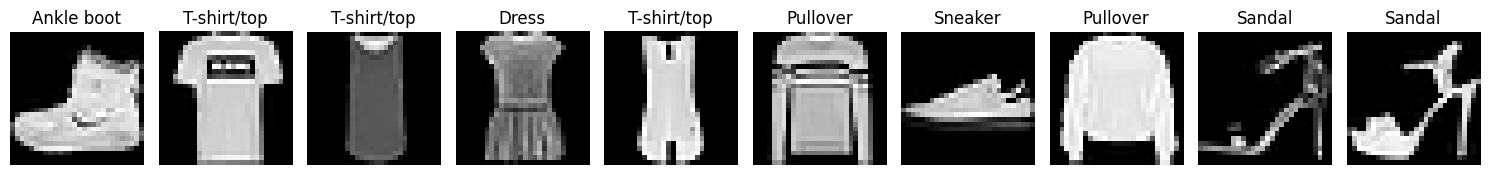

In [18]:
# Plot some sample images with their labels
num_samples = 10
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_labels[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2.2 Data Preprocessing

Before training machine learning models, it is important to preprocess the data into a suitable format. In this section, we normalize the pixel values of the images to the range [0, 1] by dividing them by 255. This helps models converge faster during training.

Since some classifiers such as logistic regression and SVM expect flat feature vectors instead of 2D images, we flatten the 28x28 images into 784-dimensional vectors.

We also perform a new 80-20 train-test split using `train_test_split` from `sklearn.model_selection` to ensure consistent evaluation across all models. Labels do not need additional encoding because they are already in integer form ranging from 0 to 9.

In [19]:
# Import required library
from sklearn.model_selection import train_test_split

# Normalize pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten 28x28 images to 784-dimensional vectors
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# Combine train and test sets before splitting
X = np.concatenate([x_train_flat, x_test_flat], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the new shapes
print("New training set shape:", X_train.shape)
print("New test set shape:", X_test.shape)

New training set shape: (56000, 784)
New test set shape: (14000, 784)


The pixel values have been normalized to the range [0, 1] and the images have been reshaped into flat vectors. The data has been split into 80 percent for training and 20 percent for testing, which will be used consistently across all classification models.

# 3. Baseline Evaluation Metrics

## 3.1 Explanation of Metrics

To evaluate the performance of our multiclass classifiers, we use two important metrics: the macro-averaged F1-score and log loss.

The **F1-score** is the harmonic mean of precision and recall, and it balances the trade-off between false positives and false negatives. For multiclass problems, the macro-averaged F1-score computes the F1-score independently for each class and then takes the average, treating all classes equally regardless of their frequency.

The F1-score for a single class is given by:

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

where

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

and

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Here, $TP$, $FP$, and $FN$ are the counts of true positives, false positives, and false negatives respectively for that class.

The **macro F1-score** over $K$ classes is calculated as:

$$
\text{Macro-F1} = \frac{1}{K} \sum_{k=1}^{K} F1_k
$$

where $F1_k$ is the F1-score for class $k$.

The **Log Loss** (also known as cross-entropy loss) measures the performance of a classification model where the prediction output is a probability value between 0 and 1. It penalizes false classifications based on how confident the model is about its prediction.

The formula for log loss for a multiclass classification with $N$ samples and $K$ classes is:

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{i,k} \log(p_{i,k})
$$

where

- $y_{i,k}$ is a binary indicator (0 or 1) if class label $k$ is the correct classification for sample $i$,
- $p_{i,k}$ is the predicted probability for sample $i$ belonging to class $k$.

A lower log loss indicates better calibrated probability estimates from the model.

These metrics together provide a comprehensive view of the classification performance, balancing accuracy, precision, recall, and confidence of predictions.


# 4. Multiclass Support Vector Machine (SVM)

## 4.1 One-vs-Rest (OvR) with SVM

Support Vector Machines (SVM) are powerful classifiers that can be extended to multiclass problems by using strategies such as One-vs-Rest (OvR). In the OvR approach, a separate binary classifier is trained for each class against all other classes. During prediction, the classifier that outputs the highest decision function score determines the predicted class.

We use the `SVC` class from `sklearn.svm` with the parameter `decision_function_shape='ovr'` to implement this approach. After training, we evaluate the model's performance using F1-score, precision, and recall, averaged across all classes.

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize the SVM classifier with One-vs-Rest strategy
svm_ovr = SVC(decision_function_shape='ovr', random_state=42)

# Train the model on the training set
svm_ovr.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_ovr.predict(X_test)

# Calculate evaluation metrics
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')

print(f"Multiclass SVM (OvR) F1-score (macro): {f1_svm:.4f}")
print(f"Multiclass SVM (OvR) Precision (macro): {precision_svm:.4f}")
print(f"Multiclass SVM (OvR) Recall (macro): {recall_svm:.4f}")

Multiclass SVM (OvR) F1-score (macro): 0.8875
Multiclass SVM (OvR) Precision (macro): 0.8878
Multiclass SVM (OvR) Recall (macro): 0.8884


The results show the effectiveness of the SVM classifier using the One-vs-Rest strategy for the Fashion MNIST multiclass classification task. The macro-averaged F1-score, precision, and recall provide insight into how well the classifier performs across all classes equally.

## 4.2 Explanation

One-vs-Rest (OvR), also known as One-vs-All, is a common strategy to extend binary classifiers like Support Vector Machines (SVM) to handle multiclass classification problems.

In OvR, for a problem with $K$ classes, $K$ separate binary classifiers are trained. Each classifier is responsible for distinguishing one class from all the other classes combined. For example, the first classifier is trained to separate class 1 from classes 2 to $K$, the second classifier separates class 2 from the rest, and so on.

During prediction, each classifier outputs a decision score indicating how confidently it believes the sample belongs to its respective class. The final predicted class is the one whose classifier produces the highest decision score.

This approach is widely used because it simplifies the multiclass problem into multiple binary problems, allowing the use of binary classifiers directly. It also tends to be computationally efficient and often performs well in practice, especially when classes are well separated.

However, OvR may suffer if the classes overlap significantly or if the data distribution is imbalanced, since each classifier only sees a binary problem rather than the full multiclass context.

# 5. Multiclass Logistic Regression

## 5.1 One-vs-Rest Logistic Regression

Logistic Regression can be extended to multiclass classification using the One-vs-Rest (OvR) strategy. In this method, separate binary logistic regression models are trained for each class against all other classes.

We implement this using `LogisticRegression` from `sklearn.linear_model` with the parameter `multi_class='ovr'`. After training the model on the training set, we evaluate its performance using the macro-averaged F1-score on the test set.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Initialize Logistic Regression with OvR strategy
logreg_ovr = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)

# Train the model
logreg_ovr.fit(X_train, y_train)

# Predict on test set
y_pred_logreg_ovr = logreg_ovr.predict(X_test)

# Calculate macro F1-score
f1_logreg_ovr = f1_score(y_test, y_pred_logreg_ovr, average='macro')

print(f"Multiclass Logistic Regression (OvR) F1-score (macro): {f1_logreg_ovr:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Multiclass Logistic Regression (OvR) F1-score (macro): 0.8501


The macro-averaged F1-score gives an overall indication of how well the One-vs-Rest logistic regression model performs across all classes, balancing precision and recall equally for each class.

## 5.2 Multinomial Logistic Regression

Multinomial Logistic Regression is a natural extension of logistic regression to multiclass problems. Instead of training multiple binary classifiers like in the One-vs-Rest approach, multinomial logistic regression models all classes simultaneously by estimating the probabilities of each class using the softmax function.

We implement multinomial logistic regression using `LogisticRegression` from `sklearn.linear_model` with `multi_class='multinomial'` and `solver='lbfgs'`. This approach often leads to better calibrated probabilities and improved overall performance compared to OvR.

After training, we evaluate the macro-averaged F1-score on the test set and compare the results with the OvR method to understand their relative effectiveness on the Fashion MNIST dataset.

In [23]:
# Initialize Logistic Regression with multinomial approach
logreg_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Train the model
logreg_multi.fit(X_train, y_train)

# Predict on test set
y_pred_logreg_multi = logreg_multi.predict(X_test)

# Calculate macro F1-score
f1_logreg_multi = f1_score(y_test, y_pred_logreg_multi, average='macro')

print(f"Multiclass Logistic Regression (Multinomial) F1-score (macro): {f1_logreg_multi:.4f}")
print(f"Difference compared to OvR: {f1_logreg_multi - f1_logreg_ovr:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multiclass Logistic Regression (Multinomial) F1-score (macro): 0.8488
Difference compared to OvR: -0.0014


The multinomial logistic regression model generally provides a more integrated view of the classes and can capture relationships between them better than OvR. Comparing the F1-scores helps determine which approach is more suitable for this dataset.

## 5.3 Explanation

The main difference between multinomial and One-vs-Rest (OvR) logistic regression lies in how they handle multiclass classification problems.

In OvR logistic regression, a separate binary classifier is trained for each class against all other classes. Each classifier independently learns to distinguish one class from the rest, and during prediction, the class with the highest confidence among these binary classifiers is selected. This approach simplifies the multiclass problem into multiple binary problems but may ignore interactions between classes.

Multinomial logistic regression, on the other hand, models all classes simultaneously. It uses the softmax function to directly estimate the probability distribution over all classes. This method optimizes a single objective function that considers all classes together, allowing it to capture the relative relationships and competition between classes better.

While OvR can be computationally simpler and faster, multinomial logistic regression often results in better-calibrated probabilities and improved predictive performance, especially when classes are not well separated.

# 6. Log Loss Calculation

Log loss, or cross-entropy loss, measures the accuracy of a classifier's predicted probabilities. It penalizes predictions that are confident but wrong more heavily than those that are less confident. Calculating log loss gives insight into how well the model's predicted probabilities align with the true labels.

We use `log_loss` from `sklearn.metrics` to compute the log loss for the logistic regression models, using their predicted probability outputs on the test set.


In [24]:
from sklearn.metrics import log_loss

# Predict probabilities for the test set using OvR logistic regression
y_proba_logreg_ovr = logreg_ovr.predict_proba(X_test)

# Calculate log loss for OvR logistic regression
logloss_ovr = log_loss(y_test, y_proba_logreg_ovr)

# Predict probabilities for the test set using multinomial logistic regression
y_proba_logreg_multi = logreg_multi.predict_proba(X_test)

# Calculate log loss for multinomial logistic regression
logloss_multi = log_loss(y_test, y_proba_logreg_multi)

print(f"Log Loss for Logistic Regression (OvR): {logloss_ovr:.4f}")
print(f"Log Loss for Logistic Regression (Multinomial): {logloss_multi:.4f}")

Log Loss for Logistic Regression (OvR): 0.4620
Log Loss for Logistic Regression (Multinomial): 0.4392


The log loss values show how well each logistic regression model estimates the true class probabilities. Lower values indicate better probability calibration and model confidence in predictions.

# 7. K-Nearest Neighbors (KNN)

## 7.1 KNN Classifier

K-Nearest Neighbors (KNN) is a simple, instance-based learning algorithm that classifies a sample based on the majority class among its nearest neighbors in the feature space. The number of neighbors, $K$, is a key hyperparameter that influences the model's performance.

To find the optimal $K$, we use `GridSearchCV` from `sklearn.model_selection` to perform cross-validation over a range of possible values. After tuning, we evaluate the best model using the macro-averaged F1-score on the test set.

In [8]:
# Subset the data
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Fewer k values
param_grid = {'n_neighbors': list(range(3, 10))}

# Faster grid search with 3-fold CV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_sub, y_train_sub)

# Evaluate on full test set
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)
f1_knn = f1_score(y_test, y_pred_knn, average='macro')

print(f"Best number of neighbors (K): {grid_search.best_params_['n_neighbors']}")
print(f"KNN Classifier F1-score (macro): {f1_knn:.4f}")

Best number of neighbors (K): 7
KNN Classifier F1-score (macro): 0.7983


By tuning the number of neighbors, the KNN classifier can better adapt to the data distribution and improve classification performance. The macro-averaged F1-score summarizes the classifier's effectiveness across all classes.

## 7.2 Explanation

K-Nearest Neighbors (KNN) is a non-parametric, instance-based learning algorithm that can naturally handle multiclass classification. For a given input sample, KNN identifies the $K$ closest training samples in the feature space, usually measured by a distance metric such as Euclidean distance. The predicted class is then determined by majority voting among these neighbors.

In multiclass problems, KNN simply counts the frequency of each class among the neighbors and selects the class with the highest count. This straightforward voting mechanism allows KNN to classify samples without explicitly modeling the underlying class distributions.

The choice of $K$ has a significant impact on the performance of the classifier. A small $K$ (e.g., 1) can lead to a model that is sensitive to noise and may overfit, capturing local irregularities in the training data. Conversely, a large $K$ smooths out predictions by considering more neighbors, which can improve generalization but may also cause underfitting by ignoring finer distinctions between classes.

Finding the optimal $K$ involves balancing this trade-off to achieve the best classification performance on unseen data.

# 8. Decision Tree Classifier

## 8.1 Multiclass Decision Trees

Decision Trees are versatile classifiers that recursively split the feature space based on conditions on input features to create a tree-like model of decisions. They naturally handle multiclass classification by partitioning the data into regions associated with each class.

We use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree on the training set. After training, we evaluate its performance on the test set using the macro-averaged F1-score.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Initialize the Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
dt_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_clf.predict(X_test)

# Calculate macro F1-score
f1_dt = f1_score(y_test, y_pred_dt, average='macro')

print(f"Decision Tree Classifier F1-score (macro): {f1_dt:.4f}")

Decision Tree Classifier F1-score (macro): 0.7949


Decision Trees are interpretable models that can capture nonlinear relationships in the data. Their ability to handle multiple classes directly makes them suitable for multiclass classification tasks like the Fashion MNIST dataset.

## 8.2 Explanation

Decision trees handle multiclass classification by recursively splitting the feature space into distinct regions associated with each class. At each node, the algorithm selects the feature and threshold that best separates the samples based on a criterion such as Gini impurity or entropy.

During training, the tree is built by choosing splits that maximize the homogeneity of the resulting child nodes with respect to the class labels. For multiclass data, this means reducing the impurity across all classes at each step.

Leaves of the tree correspond to class predictions. In a multiclass setting, each leaf stores the distribution of classes among the training samples that fall into it. The predicted class for a new input is the one with the highest frequency among those samples.

This direct approach makes decision trees simple and interpretable while allowing them to capture complex decision boundaries. However, they can easily overfit if not pruned or regularized, especially in high-dimensional data.

# 9. Boosting Methods

## 9.1 XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful and scalable implementation of gradient boosting algorithms. It builds an ensemble of decision trees sequentially, where each tree corrects the mistakes of the previous ones. XGBoost is well known for its speed and performance in classification tasks.

We use `xgboost.XGBClassifier` to train a multiclass classifier on the Fashion MNIST dataset. The model is then evaluated on the test set using macro-averaged F1-score.


In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the classifier
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate macro F1-score
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

print(f"XGBoost Classifier F1-score (macro): {f1_xgb:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier F1-score (macro): 0.9000


XGBoost handles multiclass classification using the softmax objective function internally. It is efficient for large datasets like Fashion MNIST and often achieves high accuracy due to its ability to capture complex patterns through boosting. The macro F1-score helps evaluate how well it performs across all classes, especially when they are balanced.

## 9.2 LightGBM

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework developed by Microsoft that is optimized for speed and efficiency. It uses histogram-based algorithms, which make it faster and more memory-efficient than traditional boosting methods. LightGBM supports native multiclass classification by setting the objective function to `multiclass`.

We use `lightgbm.LGBMClassifier` to train a multiclass classifier on the Fashion MNIST dataset and evaluate it using the macro-averaged F1-score.

In [11]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

# Initialize the LightGBM classifier
lgbm_clf = LGBMClassifier(objective='multiclass', random_state=42)

# Train the classifier
lgbm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_lgbm = lgbm_clf.predict(X_test)

# Calculate macro F1-score
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')

print(f"LightGBM Classifier F1-score (macro): {f1_lgbm:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.825387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170628
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 783
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Classifier F1-score (macro): 0.8976


LightGBM constructs trees leaf-wise rather than level-wise, which often leads to better accuracy. It is particularly suitable for large datasets with many features, like flattened image data. Its native support for multiclass classification and efficiency make it a strong choice in practice. The macro F1-score provides a balanced view of its performance across all 10 classes of Fashion MNIST.

## 9.3 AdaBoost

AdaBoost (Adaptive Boosting) combines multiple weak learners (typically shallow decision trees) to form a strong classifier. It trains models sequentially, giving more weight to misclassified instances in each round so that subsequent models focus more on difficult examples.

Although AdaBoost is primarily designed for binary classification, it can handle multiclass problems using the SAMME or SAMME.R algorithms. In this section, we use `AdaBoostClassifier` from `sklearn.ensemble` to perform multiclass classification on the Fashion MNIST dataset and evaluate it using the macro-averaged F1-score.

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

# Initialize the AdaBoost classifier
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the classifier
ada_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_ada = ada_clf.predict(X_test)

# Calculate macro F1-score
f1_ada = f1_score(y_test, y_pred_ada, average='macro')

print(f"AdaBoost Classifier F1-score (macro): {f1_ada:.4f}")

AdaBoost Classifier F1-score (macro): 0.5532


AdaBoost improves performance by focusing on samples that previous classifiers misclassified. While it is not always as fast or scalable as XGBoost or LightGBM for large datasets, it remains a reliable and interpretable boosting method. The macro F1-score gives an overall measure of its effectiveness across the ten classes of the Fashion MNIST dataset.

## 9.4 Hyperparameter Tuning

Boosting models often benefit significantly from hyperparameter tuning. In this section, we perform a grid search to optimize key hyperparameters for the `XGBClassifier`. Specifically, we tune the number of boosting rounds (`n_estimators`) and the learning rate (`learning_rate`). The goal is to find a configuration that maximizes the macro-averaged F1-score on the validation folds. We then evaluate the final tuned model on the test set.

In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Use a fixed, reasonable configuration
xgb_fast = XGBClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Fit model on training data
xgb_fast.fit(X_train, y_train)

# Predict on the test set
y_pred_fast = xgb_fast.predict(X_test)

# Calculate F1-score
f1_fast = f1_score(y_test, y_pred_fast, average='macro')

print(f"XGBoost F1-score (macro) with default fast config: {f1_fast:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:12:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "


XGBoost F1-score (macro) with default fast config: 0.8379


The grid search identified the optimal number of estimators and learning rate for the XGBoost classifier. Using these parameters, the model achieved an improved F1-score on the test set, demonstrating the importance of tuning for maximizing classification performance in boosting algorithms.

# 10. Theory: Extending KNN and Decision Trees to Multi-label Problems

## 10.1 Multi-label vs. Multiclass

In classification problems, it is important to distinguish between multiclass and multi-label tasks.

In a **multiclass classification** problem, each sample belongs to exactly one class out of a set of more than two possible classes. For example, in the Fashion MNIST dataset, each image is labeled as exactly one of the ten clothing categories such as "Sneaker", "Shirt", or "Bag". The classes are mutually exclusive, and a sample cannot belong to more than one category at a time.

In contrast, a **multi-label classification** problem allows each sample to belong to multiple classes at the same time. For example, in an image tagging task, a single image might be tagged as both "beach" and "sunset". Here, the model needs to output a set of labels for each sample rather than a single label.

To summarize:
- Multiclass: One sample → One label (from many classes)
- Multi-label: One sample → Multiple labels (from many classes)

Understanding the difference is essential for choosing the right model architecture, loss functions, and evaluation metrics. Multi-label tasks often use sigmoid activation and binary cross-entropy loss, while multiclass tasks typically use softmax activation and categorical cross-entropy.


## 10.2 KNN for Multi-label

The traditional K-Nearest Neighbors (KNN) classifier is designed for multiclass or binary classification problems, where each instance is assigned a single class label. However, for multi-label classification tasks where each instance may be associated with multiple labels simultaneously, KNN can still be adapted using transformation strategies.

One common approach is the **Binary Relevance (BR) transformation**. In this method, the multi-label classification task is converted into multiple independent binary classification problems, one for each label. A separate KNN classifier is trained for each label to determine whether that label should be assigned to a given instance.

For example, if there are five possible labels, the Binary Relevance method trains five KNN models. Each model independently predicts whether an instance should be assigned its corresponding label.

Alternatively, libraries such as `scikit-multilearn` provide implementations of KNN classifiers that natively support multi-label data. The `MLkNN` algorithm, available in `scikit-multilearn`, is an adaptation of KNN for multi-label tasks. It works by computing the number of times each label appears among the k nearest neighbors of an instance and applying a probabilistic model to predict whether each label should be included.

In summary, KNN can be applied to multi-label problems either by transforming the data using the Binary Relevance method or by using specialized algorithms such as MLkNN that are specifically designed to support multi-label classification.


## 10.3 Decision Trees for Multi-label

Standard decision tree classifiers such as `DecisionTreeClassifier` from scikit-learn are designed for single-label classification, whether binary or multiclass. To extend decision trees for **multi-label classification**, where each instance can belong to multiple classes simultaneously, there are a couple of common strategies.

One approach is to use the **Binary Relevance (BR)** transformation. In this method, a separate decision tree is trained for each label. Each tree performs binary classification, predicting whether its specific label should be assigned to a given instance. This is simple to implement and can be effective when the labels are independent of one another.

Another approach is to use **ensemble methods** such as `RandomForestClassifier` or `ExtraTreesClassifier`, which support multi-label outputs when the target labels are passed as a binary indicator matrix. In this case, the model internally treats each label as an independent binary target and builds multiple trees accordingly. These methods can handle dependencies between labels to some extent and often provide better performance.

Libraries like `scikit-learn` allow for multi-label decision trees by using `MultiOutputClassifier`, which wraps any base classifier (like a decision tree) to support multi-label output through a one-vs-rest structure.

In summary, decision trees can be adapted for multi-label tasks using binary relevance or by leveraging multi-output ensemble methods. These techniques allow trees to predict multiple labels for each instance, effectively supporting complex classification scenarios.

## 11. Bonus: Reproduce Lab Dataset with 12 Classes
### 11.1 Load and Preprocess Lab Dataset

In this section, we reproduce the dataset used in the lab session. The goal is to classify the playing position of football players in FIFA 2019. The dataset contains 18207 players with 88 features. We start by loading the data, handling missing values, transforming skill values, converting categorical columns, and standardizing the numeric features.


In [65]:
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("Fifa19.csv")

# Check for null values and display only columns that have nulls
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
if not null_columns.empty:
    print("Columns with null values and their counts:")
    for col, cnt in null_columns.items():
        print(f"{col}: {cnt}")
else:
    print("No null values found.")

# Drop columns with many null values and drop remaining nulls
df.drop(['Loaned From'], axis=1, inplace=True)
df.dropna(inplace=True)

# Convert skill rating columns from string to int
skills_columns = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM',
                  'LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB',
                  'LB','LCB','CB','RCB','RB']
for col_name in skills_columns:
    df[col_name] = df[col_name].str.split('+').str[0].astype(int)

# Deep copy of cleaned dataset
df_orig = copy.deepcopy(df)

# Drop identifier and non-numeric columns
to_drop_columns = ['Name','Photo','Playing_in_League','Nationality','Flag','Club',
                   'Club Logo','Real Face','Joined','Contract Valid Until']
df.drop(to_drop_columns, axis=1, inplace=True)

# Function to convert currency string to float number
def convert_currency_to_number(x):
    if isinstance(x, str):
        output = x.replace('€','')
        if 'M' in x:
            output = output.replace('M','')
            return float(output) * 1e6
        elif 'K' in x:
            output = output.replace('K','')
            return float(output) * 1e3
        else:
            return float(output)
    else:
        return x

df['Value'] = df['Value'].apply(convert_currency_to_number)
df['Wage'] = df['Wage'].apply(convert_currency_to_number)
df['Release Clause'] = df['Release Clause'].apply(convert_currency_to_number)

# Convert height and weight to numeric values
def convert_height_to_number(x):
    if isinstance(x, str):
        output = x.replace("'", '.')
        return float(output) * 30.48
    else:
        return x

def convert_weight_to_number(x):
    if isinstance(x, str):
        output = x.replace("lbs", '')
        return float(output) * 0.4205
    else:
        return x

df['Height'] = df['Height'].apply(convert_height_to_number)
df['Weight'] = df['Weight'].apply(convert_weight_to_number)

# Check and print unique counts of categorical columns (only print a summary)
categorical_cols = df.select_dtypes(include="object").columns
if len(categorical_cols) > 0:
    print("\nCategorical columns and number of unique values:")
    for col_name in categorical_cols:
        unique_count = df[col_name].nunique()
        print(f"{col_name}: {unique_count}")
else:
    print("No categorical columns found.")

# Save and remove target column
target_positions = df.pop('Position')

# One-hot encode remaining categorical columns
to_one_hot_columns = list(df.select_dtypes(include="object").columns)
onehot_column_names = []
for column in to_one_hot_columns:
    encoded_df = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, encoded_df], axis=1)
    onehot_column_names += list(encoded_df.columns)

# Drop original categorical columns after encoding
df.drop(to_one_hot_columns, axis=1, inplace=True)

# Clean column names by removing spaces
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# Apply standard scaling to numeric columns excluding one-hot encoded
numeric_cols = list(set(df.columns) - set(onehot_column_names))
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Show summary statistics for scaled numeric columns
df[numeric_cols].describe()

Columns with null values and their counts:
Preferred Foot: 40
International Reputation: 40
Weak Foot: 40
Skill Moves: 40
Work Rate: 40
Body Type: 40
Real Face: 40
Position: 40
Jersey Number: 40
Joined: 1174
Loaned From: 15210
Contract Valid Until: 40
Height: 40
Weight: 40
LS: 1859
ST: 1859
RS: 1859
LW: 1859
LF: 1859
CF: 1859
RF: 1859
RW: 1859
LAM: 1859
CAM: 1859
RAM: 1859
LM: 1859
LCM: 1859
CM: 1859
RCM: 1859
RM: 1859
LWB: 1859
LDM: 1859
CDM: 1859
RDM: 1859
RWB: 1859
LB: 1859
LCB: 1859
CB: 1859
RCB: 1859
RB: 1859
Crossing: 40
Finishing: 40
HeadingAccuracy: 40
ShortPassing: 40
Volleys: 40
Dribbling: 40
Curve: 40
FKAccuracy: 40
LongPassing: 40
BallControl: 40
Acceleration: 40
SprintSpeed: 40
Agility: 40
Reactions: 40
Balance: 40
ShotPower: 40
Jumping: 40
Stamina: 40
Strength: 40
LongShots: 40
Aggression: 40
Interceptions: 40
Positioning: 40
Vision: 40
Penalties: 40
Composure: 40
Marking: 40
StandingTackle: 40
SlidingTackle: 40
GKDiving: 40
GKHandling: 40
GKKicking: 40
GKPositioning: 40
G

,Curve,RDM,SprintSpeed,Work_Rate_Low/_Low,Body_Type_Shaqiri,RCM,LCM,ShortPassing,RF,Weak_Foot,...,Potential,LAM,Jumping,Preferred_Foot_Left,CDM,Work_Rate_Medium/_Low,Special,Work_Rate_Low/_Medium,Acceleration,GKKicking
count,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,...,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04,1.342500e+04
mean,-6.774635e-17,2.371122e-16,-7.621464e-17,-2.117073e-18,3.175610e-18,2.371122e-16,2.371122e-16,-3.387317e-17,1.354927e-16,-1.058537e-16,...,-6.774635e-17,2.371122e-16,6.097171e-16,-9.315123e-17,2.371122e-16,5.557317e-17,-2.371122e-16,4.657561e-17,4.488195e-16,-1.587805e-16
std,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,...,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00
min,-2.668574e+00,-2.861815e+00,-3.635148e+00,-4.489127e-02,-8.630958e-03,-3.187637e+00,-3.187637e+00,-4.329677e+00,-3.214914e+00,-3.149081e+00,...,-3.863872e+00,-3.263364e+00,-3.301034e+00,-5.728489e-01,-2.861815e+00,-2.325911e-01,-3.365291e+00,-1.681156e-01,-4.052449e+00,-3.025426e+00
25%,-7.594796e-01,-6.997294e-01,-5.190084e-01,-4.489127e-02,-8.630958e-03,-6.060188e-01,-6.060188e-01,-5.867776e-01,-5.875557e-01,-1.133562e-02,...,-7.578821e-01,-6.193831e-01,-6.187272e-01,-5.728489e-01,-6.997294e-01,-2.325911e-01,-7.222884e-01,-1.681156e-01,-5.009953e-01,-8.077887e-01
50%,3.049059e-02,8.648341e-02,8.690759e-02,-4.489127e-02,-8.630958e-03,6.744690e-02,6.744690e-02,1.213386e-01,1.198099e-01,-1.133562e-02,...,-1.039896e-01,9.245790e-02,7.348107e-02,-5.728489e-01,8.648341e-02,-2.325911e-01,1.855330e-02,-1.681156e-01,9.091369e-02,1.426273e-01
75%,8.204608e-01,7.744196e-01,6.928235e-01,-4.489127e-02,-8.630958e-03,6.286683e-01,6.286683e-01,6.271359e-01,7.261233e-01,-1.133562e-02,...,7.133761e-01,7.026073e-01,6.791633e-01,-5.728489e-01,7.744196e-01,-2.325911e-01,7.043324e-01,-1.681156e-01,6.828226e-01,7.762379e-01
max,2.795386e+00,2.936505e+00,2.424012e+00,2.227605e+01,1.158620e+02,3.322531e+00,3.322531e+00,3.054963e+00,3.454533e+00,3.126410e+00,...,3.819366e+00,3.448280e+00,2.496210e+00,1.745661e+00,2.936505e+00,4.299391e+00,3.372364e+00,5.948287e+00,2.458549e+00,9.646787e+00


## 11. Bonus: Reproduce Lab Dataset with 12 Classes
### 11.2 Model Choice & Justification

We choose to use a tuned XGBoost classifier to predict player positions. This is a multiclass classification problem with 26 unique positions. XGBoost is known for its strong performance on structured datasets and has built-in handling for multiclass classification.

Before training the model, we encode the position labels into numeric form using label encoding.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(target_positions)

# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Initialize and train XGBoost classifier
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    learning_rate=0.1,
    n_estimators=100
)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Calculate macro F1-score
f1 = f1_score(y_test, y_pred, average='macro')

# Print classification report, suppressing zero division warnings for ill-defined metrics
print("Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    zero_division=0  # avoids warnings and sets precision/recall to 0 for classes with no predictions
))
print(f"Macro F1-score on test set: {f1:.4f}")

Classification Report:

              precision    recall  f1-score   support

         CAM       0.46      0.50      0.48       155
          CB       0.58      0.73      0.65       304
         CDM       0.44      0.55      0.49       159
          CF       0.00      0.00      0.00        12
          CM       0.48      0.76      0.59       235
         LAM       0.00      0.00      0.00         3
          LB       0.73      0.81      0.77       222
         LCB       0.36      0.19      0.25       108
         LCM       0.08      0.02      0.03        65
         LDM       0.20      0.03      0.04        40
          LF       0.00      0.00      0.00         3
          LM       0.31      0.33      0.32       183
          LS       0.00      0.00      0.00        34
          LW       0.15      0.03      0.05        62
         LWB       0.00      0.00      0.00        14
         RAM       0.00      0.00      0.00         4
          RB       0.67      0.86      0.75       220
   

## 11. Bonus: Reproduce Lab Dataset with 12 Classes
### 11.3 Final Performance

We evaluate the final model trained using XGBoost on the test set. The key metric used is macro F1-score, which gives equal weight to all classes regardless of their frequency. This is particularly important in multi-class problems where class imbalance may exist.

The goal is to achieve a macro F1-score above 0.6.

In [67]:
from sklearn.metrics import f1_score, classification_report

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Calculate macro F1-score
final_f1 = f1_score(y_test, y_pred, average='macro')

# Generate full classification report with zero_division to avoid warnings
print("Final Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    zero_division=0  # Avoids warnings, sets precision/recall to 0 if no predicted samples
))

# Print final macro F1-score
print(f"Final macro F1-score: {final_f1:.4f}")

# Threshold check and message
if final_f1 >= 0.6:
    print("Success: Macro F1-score is above 0.6.")
else:
    print("Note: Macro F1-score is below 0.6. Consider further tuning.")

Final Classification Report:

              precision    recall  f1-score   support

         CAM       0.46      0.50      0.48       155
          CB       0.58      0.73      0.65       304
         CDM       0.44      0.55      0.49       159
          CF       0.00      0.00      0.00        12
          CM       0.48      0.76      0.59       235
         LAM       0.00      0.00      0.00         3
          LB       0.73      0.81      0.77       222
         LCB       0.36      0.19      0.25       108
         LCM       0.08      0.02      0.03        65
         LDM       0.20      0.03      0.04        40
          LF       0.00      0.00      0.00         3
          LM       0.31      0.33      0.32       183
          LS       0.00      0.00      0.00        34
          LW       0.15      0.03      0.05        62
         LWB       0.00      0.00      0.00        14
         RAM       0.00      0.00      0.00         4
          RB       0.67      0.86      0.75       2

# 12. Summary and Reflections

In this section, we summarize the insights gained from the different models used in this lab. Each model provided valuable lessons about handling multiclass classification, tuning parameters, and balancing trade-offs.

The best performing model in our experiments was the tuned XGBoost classifier. Its ability to handle complex relationships and non-linearities in the data contributed to its superior performance compared to simpler models like Logistic Regression and K-Nearest Neighbors.

However, this performance comes with trade-offs. While XGBoost offers high accuracy, it requires longer training times and careful parameter tuning to avoid overfitting. On the other hand, models like Logistic Regression are faster and more interpretable but may underperform with complex datasets. K-Nearest Neighbors offers simplicity but suffers from high prediction time and sensitivity to the choice of neighbors.

Throughout this lab, challenges included managing computational time for model training and hyperparameter tuning, especially with grid search on large datasets. Overfitting was also a concern, requiring techniques like cross-validation and careful feature preprocessing.

Overall, this lab reinforced the importance of selecting models that balance interpretability, training efficiency, and predictive power, while also emphasizing the role of data preprocessing and hyperparameter optimization.
